In [1]:
import $ivy.`com.stripe::rainier-core:0.3.2`
import $ivy.`com.stripe::rainier-notebook:0.3.2`

import $ivy.$                               

import $ivy.$                                   

In [2]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [3]:
PPrint.register(repl)


In [20]:
val franceSmoothed = List[Long](12,18,23,30,42,59,73,106,138,179,229,289,362,441,528,640,736,857,1003,1138,1282,1399,1641,1837,2053,2341,2626,2945,3163,3415,3851,4089,4231,4434,4500,4374,4230,4133,3947,3710,3708,3788,3609,3493,3603,3468,3346,3089,2895,2594,2386,2247,2052,1733,1642)

franceSmoothed: List[Long] = List(
  12L,
  18L,
  23L,
  30L,
  42L,
  59L,
  73L,
  106L,
  138L,
  179L,
  229L,
  289L,
  362L,
  441L,
  528L,
  640L,
  736L,
  857L,
  1003L,
  1138L,
  1282L,
  1399L,
  1641L,
  1837L,
  2053L,
  2341L,
  2626L,
  2945L,
  3163L,
  3415L,
  3851L,
  4089L,
  4231L,
  4434L,
  4500L,
  4374L,
  4230L,
  4133L,
...

All we really need are the ordered case numbers. I refuse to smooth these; the model should take care of that.

In [21]:
val adjacentPairs = franceSmoothed.drop(1).zip(franceSmoothed.take(franceSmoothed.size - 1))

adjacentPairs: List[(Long, Long)] = List(
  (18L, 12L),
  (23L, 18L),
  (30L, 23L),
  (42L, 30L),
  (59L, 42L),
  (73L, 59L),
  (106L, 73L),
  (138L, 106L),
  (179L, 138L),
  (229L, 179L),
  (289L, 229L),
  (362L, 289L),
  (441L, 362L),
  (528L, 441L),
  (640L, 528L),
  (736L, 640L),
  (857L, 736L),
  (1003L, 857L),
  (1138L, 1003L),
  (1282L, 1138L),
  (1399L, 1282L),
  (1641L, 1399L),
  (1837L, 1641L),
  (2053L, 1837L),
  (2341L, 2053L),
  (2626L, 2341L),
  (2945L, 2626L),
  (3163L, 2945L),
  (3415L, 3163L),
  (3851L, 3415L),
  (4089L, 3851L),
  (4231L, 4089L),
  (4434L, 4231L),
  (4500L, 4434L),
  (4374L, 4500L),
  (4230L, 4374L),
  (4133L, 4230L),
  (3947L, 4133L),
...

In [22]:
val r0 = Gamma(4, 3).latent

r0: Real = Real(0.00, Infinity)

Why are we hardcoding sigma here?? We should have a prior on that.

Also, using Normal here is massively overfitting.

But anyway, this is the model I'm transcribing.

In [23]:
val diffs = Normal(0,0.25).latentVec(adjacentPairs.size)

diffs: Vec[Real] = Vec(
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, I

This would be slightly cleaner if `Vec` implemented `scanLeft`.

It seems weird that we're allowing Rt to go negative.

In [24]:
val rts = Vec.from(diffs.toList.scanLeft(r0)(_ + _))


rts: Vec[Real] = Vec(
  Real(0.00, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity),
  Real(-Infinity, Infinity

Separating out covariates from the observation.

In [25]:
val (xs, ys) = adjacentPairs.zipWithIndex.map{case ((kt, kt_prev), i) =>
    (i, kt_prev) -> kt
}.unzip

xs: List[(Int, Long)] = List(
  (0, 12L),
  (1, 18L),
  (2, 23L),
  (3, 30L),
  (4, 42L),
  (5, 59L),
  (6, 73L),
  (7, 106L),
  (8, 138L),
  (9, 179L),
  (10, 229L),
  (11, 289L),
  (12, 362L),
  (13, 441L),
  (14, 528L),
  (15, 640L),
  (16, 736L),
  (17, 857L),
  (18, 1003L),
  (19, 1138L),
  (20, 1282L),
  (21, 1399L),
  (22, 1641L),
  (23, 1837L),
  (24, 2053L),
  (25, 2341L),
  (26, 2626L),
  (27, 2945L),
  (28, 3163L),
  (29, 3415L),
  (30, 3851L),
  (31, 4089L),
  (32, 4231L),
  (33, 4434L),
  (34, 4500L),
  (35, 4374L),
  (36, 4230L),
  (37, 4133L),
...
ys: List[Long] = List(
  18L,
  23L,
  30L,
  42L,
  59L,
  73L,
  106L,
  138L,
  179L,
  229L,
  289L,
  362L,
  441L,
  528L,
  640L,
  736L,
  857L,
  1003L,
  1138L,
  1282L,
  1399L,
  1641L,
  1837L,
  2053L,
  2341L,
  2626L,
  2945L,
  3163L,
  3415L,
  3851L,
  4089L,
  4231L,
  4434L,
  4500L,
  4374L,
  4230L,
  4133L,
  3947L,
...

In [26]:
val model =  {
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((rts(i) - 1)/7.0).exp * kt_prev
        Poisson(lambda)
    }
    Model.observe(ys, likelihoods)
}

model: Model = Model[55]

In [27]:
val trace = model.sample(EHMC(1000, 1000, 10))

Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.95 E-BFMI: 1.12 Step size: 0.02 Mass matrix: List(0.045991204586686804, 1.022295197209199, 0.012737898501577024, 0.007772536868027698, 0.007523517104855806, 0.6433492875778533, 1.2698962409837637E-4, 0.06128314835905834, 4.4336327690222137E-4, 0.21420788312902245, 0.011547027953079207, 0.0011695977240026452, 0.4276207378297791, 0.28733305589747865, 0.017998394631581194, 0.5170029916835964, 0.08216742660462292, 0.5970510111607218, 0.01003109624546214, 0.07407453382319834, 0.0036492990958916973, 0.002485004166850028, 0.002194346095345862, 0.04285897638398943, 0.0147988034115762, 0.03143854137800962, 0.059787388817639564, 0.28921879662718264, 0.21027478964093005, 0.05272061849959198, 0.2007537926641597, 0.015305571750364356, 0.09566272264212229, 0.04884131923358248, 0.8021434940498328, 1.4145887256790045E-6, 0.001070028734406493, 6.757994323120309E-4, 0.05456482902822803, 0.28346332513859396, 0.09365229832331291, 0.1325989787556847, 0.08357185232609263, 0.04411065240720688, 0.1489169603424972, 0.11080738091064857, 0.0238065792099472, 0.0025205118677314713, 0.07137299035348611, 0.0017392449472574602, 0.07283713865124039, 0.029026488389489985, 0.008617975816690769, 0.004619052809953419, 0.4808937799312912) Total gradient evaluations: 3e+05 (14us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.93 E-BFMI: 0.96 Step size: 0.02 Mass matrix: List(0.09052730846201072, 1.0668289000507931, 0.44718501803803207, 0.09047549543126095, 0.1600760414430739, 0.001894560904762662, 1.0315903199762853, 0.019532113796685523, 0.09600182269579913, 0.016932137070848664, 0.013688176039974624, 0.0014455708656100294, 1.076169837817342, 0.0027052959155269706, 0.29433169461251946, 0.1593989102354354, 0.20717222421722578, 0.09553163479480652, 0.007379610507699677, 0.05438015938037944, 0.20155484036124358, 0.09234922801613468, 0.0014751530521014524, 0.01703385299142306, 0.026667243170493505, 0.05765045717620706, 0.10952100807910352, 0.0760376828158652, 1.0456501799865647E-5, 0.00559109960622682, 0.06615315885821146, 0.16560125229581601, 3.897638997005908E-5, 0.35400543589243955, 0.10413467967483916, 0.00597715253518667, 0.1473782207483464, 0.1423890129881673, 0.15401267109193512, 0.8911797763653984, 0.08734289341372896, 0.08596015938945639, 0.004012345896950435, 0.048697891041584535, 0.003281826713844238, 0.4202772245671333, 0.16709274457829115, 0.04212667560766973, 0.2459851718789509, 0.6988370925303384, 0.012325693355647963, 0.3777330413640468, 0.04019787762059624, 0.5244052618570839, 0.059668567905901686) Total gradient evaluations: 3e+05 (14us) Total time: 19s

Chain 3 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.90 E-BFMI: 0.98 Step size: 0.04 Mass matrix: List(0.007459903980797418, 0.08633683590720055, 0.08339292583783575, 0.16068645220745978, 0.13524627409452142, 0.036206538755906924, 0.3773456404515928, 0.015082365974869063, 0.19382003306252402, 0.0017924928637341503, 0.6531274698874574, 0.1751036307435052, 7.380973020806203E-4, 0.12495897506751313, 0.2782319278842296, 1.1219608330111102, 0.004393067944934971, 0.005283428539400858, 0.06415137465745234, 0.8365956457001291, 0.12271430773227933, 0.12354279992921466, 0.23697700452006945, 0.028438024843706583, 0.1473555735527772, 0.024779246073475366, 0.16722936582942344, 0.019142520601778817, 0.13097258166519138, 0.006412861153945897, 0.02244699701259234, 0.008723258870885132, 0.03450802851246616, 0.010373188572558116, 0.38517297384636323, 0.021247656412776754, 0.08884265882466745, 0.04235305907173872, 0.03867722084493675, 0.3479143309422823, 0.005934037215306608, 0.5667510276624036, 0.2575475996517816, 0.08531780516420974, 0.12061308449106997, 6.063634755422638E-4, 0.5888523038367591, 0.046049748087247225, 0.3238170830569597, 0.003128655317078511, 0.1643159261052549, 0.013500504530850952, 0.16851768013599014, 0.0062808884174977205, 0.29373503259117206) Total gradient evaluations: 3e+05 (18us) Total time: 23s

Chain 4 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.92 E-BFMI: 0.88 Step size: 0.04 Mass matrix: List(0.006172830947587233, 0.012906497182394184, 0.06906275650754212, 0.21697805606091536, 0.08995749990580652, 0.30963610472324354, 0.2742412647420318, 0.4001225096086785, 0.06863962645602689, 0.008907896495454964, 0.06892212702824206, 0.1918406029638312, 0.9375411938787083, 0.06469402054926626, 0.002031489097275012, 0.11801790083784598, 0.342495302752202, 9.84802402849833E-4, 2.8856281520041135E-5, 0.0011771307329198212, 0.007993312409395794, 0.19805739491029573, 0.9386470376269032, 0.028404715589893506, 0.016948228127561374, 0.034385876786324335, 0.07190818200056151, 0.4981890222257441, 0.01442439104890235, 0.09002943014151786, 0.22612320249411613, 0.20033962630089894, 0.0024353542980686204, 0.2548665981587951, 0.048525629500613905, 0.03231077557563833, 0.009903100711450227, 0.05860528305266757, 0.06298857617362111, 0.3875416170941619, 0.06972633517250863, 0.280068089689841, 0.01443272806902761, 0.5560879875894995, 0.6633963462890765, 0.0032766166666703843, 0.26179349738917296, 0.013610811130289389, 0.004556493217821154, 0.12648639622452876, 0.22832526133967768, 0.003928038156486471, 0.6682189728588247, 0.40022535102926765, 0.07473698288275259) Total gradient evaluations: 3e+05 (15us) Total time: 24s

trace: Trace = Trace[4][1000][55]

In [28]:
trace.diagnostics

res27: List[Trace.Diagnostics] = List(
  Diagnostics(1.0063573238555719, 545.8582488308233),
  Diagnostics(0.9998600206176027, 432.09654648548724),
  Diagnostics(1.006918233189342, 623.3174308745627),
  Diagnostics(1.010095938866143, 393.1472661057085),
  Diagnostics(1.0047717436486954, 444.73010913215205),
  Diagnostics(1.0102856605586588, 198.74063823588543),
  Diagnostics(1.0083098890046978, 91.93606740838862),
  Diagnostics(1.0026701080780436, 571.2823785450245),
  Diagnostics(1.000293963958087, 311.81730884573915),
  Diagnostics(0.9999830811447579, 493.10038162229625),
  Diagnostics(1.002728356084261, 388.01885787085456),
  Diagnostics(1.005379587586688, 77.8043048429335),
  Diagnostics(1.0008241593438671, 337.39549899917546),
  Diagnostics(1.0015266834605892, 201.20060543042757),
  Diagnostics(1.0058854801059958, 419.1500094019179),
  Diagnostics(1.0000677048191295, 570.2104921776296),
  Diagnostics(0.999787142135075, 706.3265202025582),
  Diagnostics(1.0011435598056135, 567.8689

In [29]:
val rtForecasts = trace.predict(rts)

rtForecasts: List[Seq[Double]] = List(
  List(
    2.8702383396963684,
    3.1347232629223685,
    3.0326588849386322,
    3.0067810530157884,
    2.8347379919197353,
    2.6271184495429276,
    2.7240547703732725,
    2.8362481243599085,
    2.8801035190968296,
    2.913796750535411,
    2.216063192405386,
    2.1773957942922317,
    2.019362612569668,
    2.276750507462997,
    2.0082788774921663,
    1.88307940346054,
    1.7207488699087035,
    1.7768546839306993,
    1.8775288145266416,
    1.709652261547021,
    1.8806654794593647,
    2.1682684934916034,
    1.7272917334697988,
    1.6911376192401097,
    1.944964478457335,
    1.721884701044847,
    1.760607755027065,
    1.5947796450475809,
    1.6647241525719867,
    1.8922793589890203,
    1.4605852070490493,
    1.2630453833417608,
    1.3597539110651848,
    1.0928153181583438,
    0.784855210991654,
    0.7808249145922634,
    1.0355852398631133,
...

In [30]:
val means = 0.until(rts.size).map{i => (i, mean(rtForecasts.map(_(i))))}

means: collection.immutable.IndexedSeq[(Int, Double)] = Vector(
  (0, 3.193154045065354),
  (1, 3.156915469902299),
  (2, 3.125493461895119),
  (3, 3.085290285109272),
  (4, 3.047545845398973),
  (5, 2.9849404894489444),
  (6, 2.957176034074607),
  (7, 2.859256450647117),
  (8, 2.7903654297263656),
  (9, 2.707667565906496),
  (10, 2.6051129804579576),
  (11, 2.512268104716885),
  (12, 2.401644925809652),
  (13, 2.3043496409615236),
  (14, 2.2461629416612507),
  (15, 2.0915778723018277),
  (16, 2.0624792582549643),
  (17, 2.0226049961473347),
  (18, 1.9196553574151567),
  (19, 1.8312970988953654),
  (20, 1.752236639007656),
  (21, 1.959424085521875),
  (22, 1.8229922488546364),
  (23, 1.8090321158740994),
  (24, 1.8770006095255862),
  (25, 1.808081970697935),
  (26, 1.7544149697143112),
  (27, 1.5510382400871243),
  (28, 1.5778427584143446),
  (29, 1.7440405869258968),
  (30, 1.4420216868659372),
  (31, 1.2708049974274678),
  (32, 1.2964315705974885),
  (33, 1.0930056167035032),
  (34, 

In [31]:
val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}

hdpis: collection.immutable.IndexedSeq[(Int, (Double, Double))] = Vector(
  (0, (2.355775044541594, 3.894734109233304)),
  (1, (2.46933945940112, 3.823193491179944)),
  (2, (2.4481769467283345, 3.7933620881894656)),
  (3, (2.447930897125194, 3.7209450388439422)),
  (4, (2.4910085060147615, 3.605483674498766)),
  (5, (2.42314670151962, 3.4527857012152774)),
  (6, (2.467492249662988, 3.4533110575988935)),
  (7, (2.428912985104174, 3.292142344884597)),
  (8, (2.397694786690578, 3.2158932083489202)),
  (9, (2.365450438071314, 3.1329525284479627)),
  (10, (2.2570064342672094, 2.9765457312105346)),
  (11, (2.1785673536262156, 2.8529758064752087)),
  (12, (2.0759535794687416, 2.7223380748313075)),
  (13, (2.033478369295781, 2.6108078348073245)),
  (14, (1.9678490740504022, 2.5355596422997015)),
  (15, (1.8269502314258015, 2.359691843314714)),
  (16, (1.8107041077431507, 2.3328357516640756)),
  (17, (1.7841276754074196, 2.2804566260101513)),
  (18, (1.6579036244352525, 2.1448202042388553)),
  

Presumably because I refused to smooth, this output is awful 

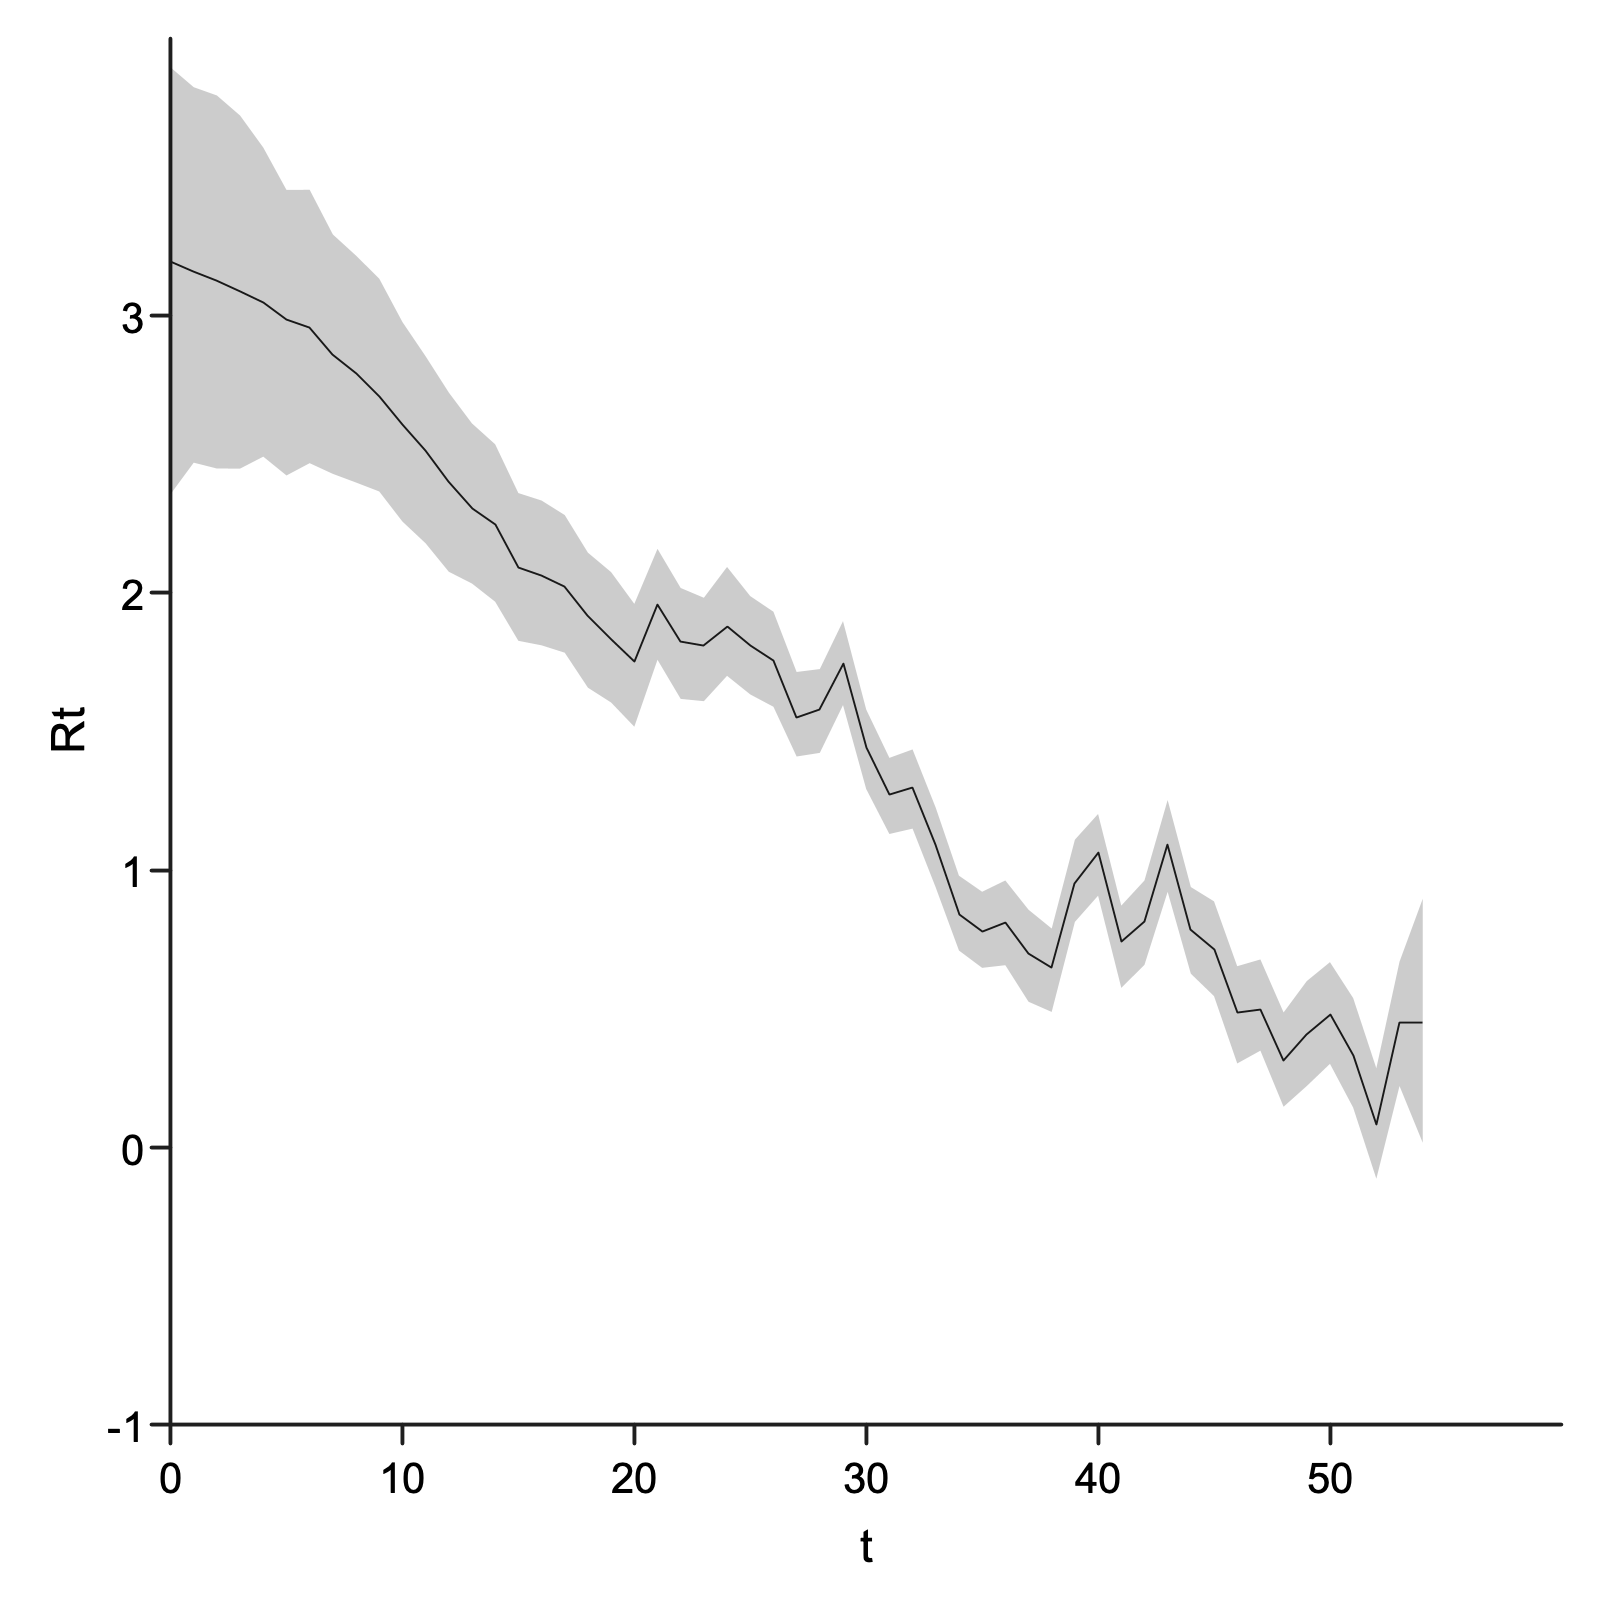

In [32]:
show("t", "Rt", line(means), shade(hdpis))